<a href="https://colab.research.google.com/github/hyun910219/spark-nlp-book/blob/master/colab/2_5_Processing_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.1

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
     |████████████████████████████████| 215.7 MB 52 kB/s 
     |████████████████████████████████| 197 kB 19.9 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130392 sha256=a5e1a9e25455d152637c251041277fd7a1ab2392bab8c2663e75ea4f8048b6f3
  Stored in directory: /root/.cache/pip/wheels/11/48/19/c3b6b66e4575c164407a83bc065179904ddc33c9d6500846f0
Successfully built pyspark
     |████████████████████████████████| 121 kB 5.4 MB/s 


In [3]:
! mkdir -p data

In [4]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz

--2021-12-03 05:07:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1860687 (1.8M) [application/x-httpd-php]
Saving to: ‘mini_newsgroups.tar.gz’

mini_newsgroups.tar 100%[===================>]   1.77M  5.07MB/s    in 0.4s    

2021-12-03 05:08:00 (5.07 MB/s) - ‘mini_newsgroups.tar.gz’ saved [1860687/1860687]



In [5]:
! tar xzf mini_newsgroups.tar.gz -C ./data/

# 5장 단어처리
5장에서는 NLP를 시작할 때 적용할 수 있는 기본 단어 처리 기술인 토큰화, 어휘 감소, bow(bag-of-word), ngram을 다룸.

In [6]:
import os

from pyspark.sql.types import *
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher

spark = sparknlp.start()

In [7]:
space_path = os.path.join('data', 'mini_newsgroups', 'sci.space')
texts = spark.sparkContext.wholeTextFiles(space_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema).persist()

In [8]:
## excerpt from mini newsgroups modified for examples
example = '''
Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.
'''

example = spark.createDataFrame([('.', example)], schema=schema).persist()

# 5.1 토큰화

텍스트와 음성 데이터는 순차적인 데이터이다. 이 순차적인 데이터를 의미가 있는 단위로 구분하는 것을 토큰화라고 한다.
영어를 비롯한 단어 구분 기호를 사용하는 기타 언어에서는 정규식으로 토큰화하는 것이 일반적이다.

In [9]:
from pyspark.ml.feature import RegexTokenizer

ws_tokenizer = RegexTokenizer()\
    .setInputCol('text')\
    .setOutputCol('ws_tokens')\
    .setPattern('\\s+')\
    .setGaps(True)\
    .setToLowercase(False)

text, tokens = ws_tokenizer.transform(example)\
    .select("text", "ws_tokens").first()

In [10]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



구두점도 포함하여 분리해보자.


In [11]:
b_tokenizer = RegexTokenizer()\
    .setInputCol('text')\
    .setOutputCol('b_tokens')\
    .setPattern('\\s+|\\b')\
    .setGaps(True)\
    .setToLowercase(False)

text, tokens = b_tokenizer.transform(example)\
    .select("text", "b_tokens").first()

In [12]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [13]:
print(tokens)

['Nick', "'", 's', 'right', 'about', 'this', '.', 'It', "'", 's', 'always', 'easier', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', 'Britan', "'", 's', 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'american', 'subjects', 'to', 'cross', 'the', 'alleghany', '/', 'appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', 'couldn', "'", 't', '.']


구두점이 구분되어 있지만 축약형이 문제가 됨. (it's -> "it", "'", "s")

sparkNLP 토크나이저는 정규식보다 정교함
다음과 같은 매개 변수를 사용함
- compositeTokens : These are multitoken words that you may not want to split (e.g., "New York"). 
- targetPattern : This is the basic pattern for defining candidate tokens. / 기본 패턴
- infixPattern : These are the patterns for separating tokens that are found inside candidate tokens. / 기본 패턴에서 분리된 토큰을 분리하는 패턴
- prefixPattern : This is the pattern for separating tokens that are found at the beginning of candidate tokens. / 기본 패턴에서 분리되는 시작  토큰을 분리하는 패턴
- suffixPattern : This is the pattern for separating tokens that are found at the end of candidate tokens. / 기본 패턴에서 분리된 끝 토큰을 분리하는 패턴

알고리즘은
1. 복합 토큰을 보호한다. (compositeTokens)
2. 예비 토큰을 생성한다. (targetPattern)
3. 접두사(prefixPattern), 접요사(infixPattern) 및 접미사(suffixPattern) 패턴을 구분한다.

In [14]:
from sparknlp.annotator import Tokenizer

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')

finisher = Finisher()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCols(['tokens'])\
    .setOutputAsArray(True)

pipeline = Pipeline()\
    .setStages([assembler, tokenizer, finisher])

text, tokens = pipeline.fit(texts).transform(example)\
    .select("text", "tokens").first()

In [15]:
toeknizer_pattern = tokenizer.extractParamMap()

for k in toeknizer_pattern.keys():
  print(k , " : ", toeknizer_pattern[k])

Tokenizer_822bb68b220b__lazyAnnotator  :  False
Tokenizer_822bb68b220b__targetPattern  :  \S+
Tokenizer_822bb68b220b__contextChars  :  ['.', ',', ';', ':', '!', '?', '*', '-', '(', ')', '"', "'"]
Tokenizer_822bb68b220b__caseSensitiveExceptions  :  True
Tokenizer_822bb68b220b__minLength  :  0
Tokenizer_822bb68b220b__maxLength  :  99999
Tokenizer_822bb68b220b__inputCols  :  ['doc']
Tokenizer_822bb68b220b__outputCol  :  tokens_annotations


In [16]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [17]:
print(tokens)

["Nick's", 'right', 'about', 'this', '.', "It's", 'always', 'easier', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'american', 'subjects', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


# 5.2 어휘 감소
NLP 작업은 텍스트를 벡터로 변환하는 작업을 함. 이 벡터 작업은 벡터의 차원이 어휘와 같으며 암묵적인 가정은 단어가 서로 직교함.

<example>. 

단어 (dog, cat, horse)   
벡터 차원 3. 

dog = [1, 0, 0]. 
cat = [0, 1, 0]. 
horse = [0, 0, 1]. 

이런 경우 단어 간의 관계를 나타낼 수가 없게 된다. 예를 들면 dog와 cat은 사람들이 집에서 많이 키우고 대부분 반려동물로 생각한다. 하지만 horse의 경우 dog와 cat과는 다르다. 그래서 dog와 cat관계와 dog와 horse의 관계는 다를 것이지만 위와 같이 표현한다면 같게 나타낸다. 이것을 더 복잡하게 공간에 표현하여 관계를 나타내는 것은 이후 10장과 11장에서 다룰 것임.

## 5.2.1 어간 추출 (stemming)

어간 추출은 점사(affix)를 제거하고 어간(word stem)을 남기는 과정. (대부분 미리 정의된 어간 추출기를 사용함. example snowball framework). 약간의 오류가 있음
- example
  - formalize → formal , allowance → allow, electricical → electric

## 5.2.2 표제어 추출 (lemmatization)
표제어 추출은 단어를 기본형인 표제어(lemma) 또는 대표어(head-word)로 변경하는 과정. 
- exapmle
  - has -> have,  watched -> watch

## 5.2.3 어간 추출 대 표제어 추출
- 어간 추출을 사용할 때
  - 어휘를 얼마나 줄일지 조정해야 한다.
  - 메모리 제약이 엄격하고 시간 제약이 적다.
  - 새 단어나 알 수 없는 단어가 많이 필요하다.

- 표제어 추출을 사용할 때
  - 사용자에게 노출되는 처리 결과가 필요하다.
  - 시간 제약이 심하고 메모리 제약이 적다.

In [18]:
from sparknlp.annotator import Stemmer, Lemmatizer, LemmatizerModel

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')

stemmer = Stemmer()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('stems_annotations')

# The next line downloads lemmatizer "model". Here, "training" 
# is reading the user supplied dictionary
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('lemma_annotations')

finisher = Finisher()\
    .setInputCols(['stems_annotations', 'lemma_annotations'])\
    .setOutputCols(['stems', 'lemmas'])\
    .setOutputAsArray(True)

pipeline = Pipeline()\
    .setStages([
        assembler, tokenizer, stemmer, lemmatizer, finisher])
text, stems, lemmas = pipeline.fit(texts).transform(example)\
    .select("text", "stems", "lemmas").first()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [19]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [20]:
print(stems)

["nick'", 'right', 'about', 'thi', '.', "it'", 'alwai', 'easier', 'to', 'obtian', 'forgiv', 'than', 'permiss', '.', 'not', 'mani', 'poepl', 'rememb', 'that', "britan'", 'kng', 'georg', 'iii', 'expressli', 'forbad', 'hi', 'american', 'subject', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountain', '.', 'said', 'subject', 'basic', 'said', ',', '"', 'stop', 'u', 'if', 'you', 'can', '."', 'he', "couldn't", '.']


In [21]:
print(lemmas)

["Nick's", 'right', 'about', 'this', '.', "It's", 'always', 'easy', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbid', 'he', 'american', 'subject', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountain', '.', 'Said', 'subject', 'basically', 'say', ',', '"', 'Stop', 'we', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


Some examples to note:

forbaed -> 어간추출 forbad, 표제어 forbid

## 5.2.4 맞춤법 교정

spark nlp에는 맞춤법을 교정하는 방밥으론 2가지가 있다. 
- 1. 대칭 삭제 철자 교정 알고리즘 : 검색할 때 정확한 단어셋이 필요
- 2. 피터 노빅의 철자 교정 알고리즘 : 정확한 어휘 필요. 확률 모델을 생성하여 작동

아래에 사전에 학습된 노빅 철자 교정법을 살펴보자

In [22]:
from sparknlp.annotator import NorvigSweetingModel
from sparknlp.annotator import SymmetricDeleteModel

In [23]:
# Norvig pretrained
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
finisher = Finisher()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCols(['norvig'])\
    .setOutputAsArray(True)

pipeline = Pipeline()\
    .setStages([
    assembler, tokenizer, norvig_pretrained, lemmatizer, finisher])
text, norvig = pipeline.fit(texts).transform(example)\
    .select("text", "norvig").first()

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]


In [24]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [25]:
print(norvig)

['Nicks', 'right', 'about', 'this', '.', 'Itys', 'always', 'easier', 'to', 'obtain', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'people', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'americana', 'subjects', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


보면 obtain, people, britan이 교정됨을 알 수 있다. 하짐나 kng는 누락되고 American은 Americana로 변환되었다. 대문자가 문제일 수 있음. 이것들은 확률 모델을 어렵게 만든다.

## 5.2.5 정규화

정규화는 데이터를 처리할 때 남아있는데 태그나 HTML과 같은 것을 제거하는 작업이다. 이것을 제거하면 어휘를 상당히 줄일 수 있다.

In [26]:
from sparknlp.annotator import Normalizer

In [27]:
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCol('lemma_annotations')
normalizer = Normalizer()\
    .setInputCols(['lemma_annotations'])\
    .setOutputCol('normtoken_annotations')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normtoken_annotations'])\
    .setOutputCols(['normtokens'])\
    .setOutputAsArray(True)

sparknlp_pipeline = Pipeline().setStages([
    assembler, tokenizer, norvig_pretrained, 
    lemmatizer, normalizer, finisher
])

pipeline = Pipeline()\
    .setStages([
        assembler, tokenizer, norvig_pretrained, 
        lemmatizer, normalizer, finisher])
text, normalized = pipeline.fit(texts).transform(example)\
    .select("text", "normtokens").first()

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [54]:
normalizer

Normalizer_b2c91fd689d7

In [28]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [29]:
print(normalized)

['nicks', 'right', 'about', 'this', 'dts', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']


# 5.3 BoW

앞의 전처리 과정을 통해서 필요한 어휘만 남겼다고 할 수 있다. 다음은 이 단어들을 벡터로 표현해주는 것이 필요하다. 우선 가장 간단한 bag-of-words이라 불리는 것을 살펴볼 것이다. BoW는 문서에 있는 단어의 개수를 말한다. 우선은 고유한 단어를 인덱스에 매핑함으로써 그들을 벡터로 바꾼다.

In [30]:
text = "the cat in the hat"
tokens = text.split()
tokens

['the', 'cat', 'in', 'the', 'hat']

In [31]:
from collections import Counter

counts = Counter(tokens)
counts

Counter({'cat': 1, 'hat': 1, 'in': 1, 'the': 2})

In [32]:
index = {token: ix for ix, token in enumerate(counts.keys())}
index

{'cat': 1, 'hat': 3, 'in': 2, 'the': 0}

In [33]:
import numpy as np

vec = np.zeros(len(index))

for token, count in counts.items():
    vec[index[token]] = count
    
vec

array([2., 1., 1., 1.])

위의 예제는 간단한 예제이며 실제로는 큰 말뭉치(corpus)에 작업하는 경우에는 훨씬 많은 단어를 가진다. 말뭉치에는 수만개에서 수십만개에 달하는 일이 흔하다. 그래서 이 벡터를 sparse vector로 주로 표현한다. 이 모든 것들은 spark에서 CountVectorizer를 사용하여 BoW를 생성할 수 있다.

# 5.4 CountVectorizer

In [55]:
from pyspark.ml.feature import CountVectorizer

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCol('lemma_annotations')
normalizer = Normalizer()\
    .setInputCols(['lemma_annotations'])\
    .setOutputCol('normtoken_annotations')\
    .setLowercase(True)
    
finisher = Finisher()\
    .setInputCols(['normtoken_annotations'])\
    .setOutputCols(['normtokens'])\
    .setOutputAsArray(True)

sparknlp_pipeline = Pipeline().setStages([
    assembler, tokenizer, norvig_pretrained, 
    lemmatizer, normalizer, finisher
])

count_vectorizer = CountVectorizer()\
    .setInputCol('normtokens')\
    .setOutputCol('bows')

pipeline = Pipeline().setStages([sparknlp_pipeline, count_vectorizer])
model = pipeline.fit(texts)
processed = model.transform(example)
text, normtokens, bow = processed\
    .select("text", "normtokens", 'bows').first()

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [56]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [57]:
print(normtokens)

['nicks', 'right', 'about', 'this', 'its', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']


결과를 살파보면 0번 단어는 1번,3번 단어는 2번 나타난다는 의미이다

In [58]:
bow

SparseVector(5443, {0: 1.0, 3: 2.0, 8: 1.0, 14: 1.0, 16: 1.0, 24: 1.0, 28: 1.0, 30: 2.0, 32: 1.0, 45: 1.0, 52: 1.0, 68: 1.0, 78: 2.0, 122: 1.0, 128: 1.0, 150: 1.0, 178: 1.0, 226: 1.0, 343: 1.0, 357: 1.0, 462: 1.0, 710: 1.0, 900: 1.0, 1045: 1.0, 1204: 1.0, 1371: 1.0, 1694: 1.0, 1822: 1.0, 2242: 1.0, 2426: 1.0, 3866: 1.0, 4118: 1.0, 4220: 1.0, 4279: 1.0, 4512: 1.0, 4992: 1.0, 5042: 1.0})

아래는 vocab을 확인할 수 있다.

In [59]:
count_vectorizer_model = model.stages[-1]

vocab = count_vectorizer_model.vocabulary
print(vocab[:20])

['the', 'be', 'of', 'to', 'and', 'a', 'in', 'for', 'that', 'on', 'have', 'it', 'i', 'from', 'you', 'space', 'this', 'they', 'as', 'by']


이 작업의 단점은 구문에서 전달되는 의미를 잃는다는 것이다.

# 5.5 N-gram
 Bow를 사용할 때 주요 단점은 개별 단어와 문서 전체 문맥으로 인코딩된 의미만 사용한다는 점이다. 언어에서는 구소 문맥에서도 많은 의미를 내포한다. 이 의미를 담는 것은 어려운 작업이지만 n-gram을 사용하면 간단하게 문맥의 일부를 추출할 수 있다. n-gram은 텍스트에 있는 n개 항목의 연속된 단어로, 작은 문맥에서 정보를 추출할 수 있다.

In [60]:
text = "the quick brown fox jumped over the lazy dog"
tokens = ["the", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog"]
unigrams = [('the',), ('quick',), ('brown',), ('fox',), ('jumped',), ('over',), ('the',), ('lazy',), ('dog',)]
bigrams = [('the', 'quick'), ('quick', 'brown'), ('brown', 'fox'), ('fox', 'jumped'), ('jumped', 'over'), ('over', 'the'), ('the', 'lazy'), ('lazy', 'dog')]
trigrams = [('the', 'quick', 'brown'), ('quick', 'brown', 'fox'), ('brown', 'fox', 'jumped'), ('fox', 'jumped', 'over'), ('jumped', 'over', 'the'), ('over', 'the', 'lazy'), ('the', 'lazy', 'dog')]

우리는 n을 결정해야하는데 보통 4보다 낮은 값으로 정한다. 도메인에 따라 n을 설정해야한다.

In [61]:
from pyspark.ml.feature import NGram

bigrams = NGram()\
    .setN(2)\
    .setInputCol("normtokens")\
    .setOutputCol("bigrams")
    
trigrams = NGram()\
    .setN(3)\
    .setInputCol("normtokens")\
    .setOutputCol("trigrams")

pipeline = Pipeline().setStages([sparknlp_pipeline, bigrams, trigrams])
model = pipeline.fit(texts)
processed = model.transform(example)
text, normtokens, bigrams, trigrams = processed\
    .select("text", "normtokens", 'bigrams', 'trigrams').first()

In [62]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [63]:
print(normtokens)

['nicks', 'right', 'about', 'this', 'its', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']


In [64]:
print(bigrams)

['nicks right', 'right about', 'about this', 'this itys', 'itys always', 'always easy', 'easy to', 'to obtain', 'obtain forgiveness', 'forgiveness than', 'than permission', 'permission not', 'not many', 'many people', 'people remember', 'remember that', 'that britans', 'britans kng', 'kng george', 'george iii', 'iii expressly', 'expressly forbid', 'forbid he', 'he americana', 'americana subject', 'subject to', 'to cross', 'cross the', 'the alleghanyappalachian', 'alleghanyappalachian mountain', 'mountain said', 'said subject', 'subject basically', 'basically say', 'say stop', 'stop we', 'we if', 'if you', 'you can', 'can he', 'he couldnt']


In [65]:
print(trigrams)

['nicks right about', 'right about this', 'about this its', 'this its always', 'its always easy', 'always easy to', 'easy to obtain', 'to obtain forgiveness', 'obtain forgiveness than', 'forgiveness than permission', 'than permission not', 'permission not many', 'not many people', 'many people remember', 'people remember that', 'remember that britans', 'that britans kng', 'britans kng george', 'kng george iii', 'george iii expressly', 'iii expressly forbid', 'expressly forbid he', 'forbid he americana', 'he americana subject', 'americana subject to', 'subject to cross', 'to cross the', 'cross the alleghanyappalachian', 'the alleghanyappalachian mountain', 'alleghanyappalachian mountain said', 'mountain said subject', 'said subject basically', 'subject basically say', 'basically say stop', 'say stop we', 'stop we if', 'we if you', 'if you can', 'you can he', 'can he couldnt']


# 5.6 시각화 : 단어 및 문서 분산

In [68]:
from sparknlp.pretrained import PretrainedPipeline

space_path = os.path.join('data', 'mini_newsgroups', 'sci.space')
space = spark.sparkContext.wholeTextFiles(space_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

space = spark.createDataFrame(space, schema=schema).persist()

# The explain_document_ml is a pretrained pipeline that we can use to process text with a simple pipeline that performs basic processing steps and recognizes entities . It performs most of the common text processing tasks on your dataframe
sparknlp_pipeline = PretrainedPipeline(
    'explain_document_ml', lang='en').model

normalizer = Normalizer()\
    .setInputCols(['lemmas'])\
    .setOutputCol('normalized')\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)

count_vectorizer = CountVectorizer()\
    .setInputCol('normalized')\
    .setOutputCol('bows')

pipeline = Pipeline().setStages([
    sparknlp_pipeline, normalizer, finisher, count_vectorizer])
model = pipeline.fit(space)
processed = model.transform(space)

explain_document_ml download started this may take some time.
Approx size to download 9.4 MB
[OK!]


In [69]:
processed.show()

+--------------------+--------------------+--------------------+--------------------+
|                path|                text|          normalized|                bows|
+--------------------+--------------------+--------------------+--------------------+
|file:/content/dat...|Newsgroups: sci.s...|[newsgroups, scis...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Newsgroups: sci.s...|[newsgroups, scis...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Xref: cantaloupe....|[pref, cantaloupe...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Xref: cantaloupe....|[tref, cantaloupe...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Xref: cantaloupe....|[xref, cantaloupe...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Xref: cantaloupe....|[pref, cantaloupe...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Path: cantaloupe....|[path, cantaloupe...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Newsgroups: sci.s...|[newsgroups, scis...|(5439,[0,1,2,3,4,...|
|file:/content/dat...|Path: cantaloupe....|[path, cant

In [46]:
vocabulary = model.stages[-1].vocabulary
word_counts = Counter()

for row in processed.toLocalIterator():
    for ix, count in zip(row['bows'].indices, row['bows'].values):
        word_counts[vocabulary[ix]] += count

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

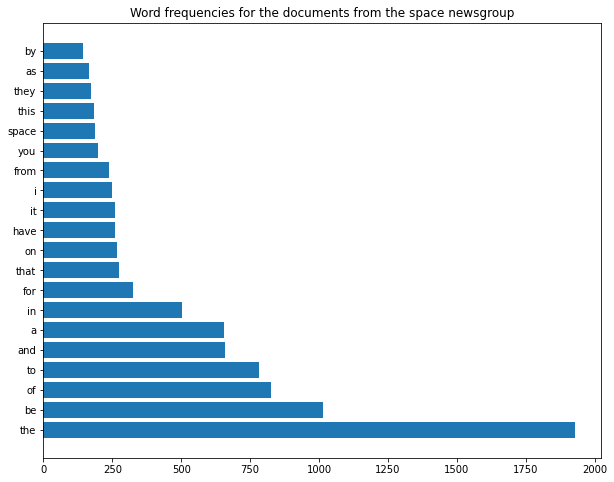

In [48]:
y = list(range(20))
top_words, counts = zip(*word_counts.most_common(20))

plt.figure(figsize=(10, 8))
plt.barh(y, counts)
plt.yticks(y, top_words)
plt.title('Word frequencies for the documents from the space newsgroup')
plt.show()

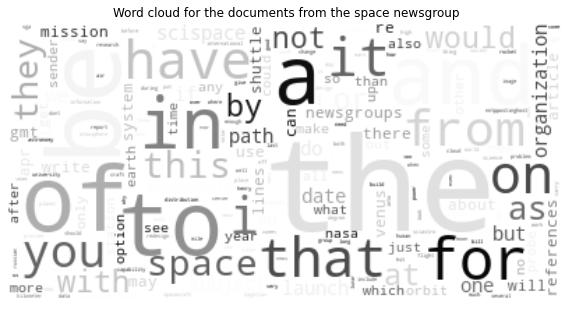

In [49]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 8))
wc = WordCloud(colormap='Greys', background_color='white')
im = wc.generate_from_frequencies(word_counts)
plt.imshow(im, interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud for the documents from the space newsgroup')

plt.show()

In [50]:
autos_path = os.path.join('data', 'mini_newsgroups', 'rec.autos')
autos = spark.sparkContext.wholeTextFiles(autos_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

autos = spark.createDataFrame(autos, schema=schema).persist()

model = pipeline.fit(autos)
processed = model.transform(autos)

In [51]:
vocabulary = model.stages[-1].vocabulary
word_counts = Counter()

for row in processed.toLocalIterator():
    for ix, count in zip(row['bows'].indices, row['bows'].values):
        word_counts[vocabulary[ix]] += count

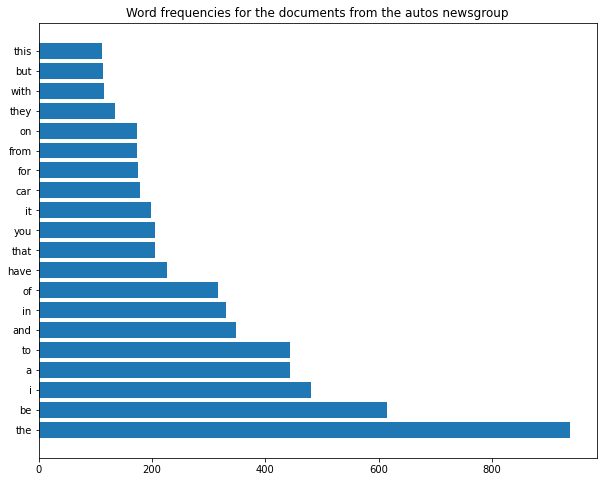

In [52]:
y = list(range(20))
top_words, counts = zip(*word_counts.most_common(20))

plt.figure(figsize=(10, 8))
plt.barh(y, counts)
plt.yticks(y, top_words)
plt.title('Word frequencies for the documents from the autos newsgroup')
plt.show()

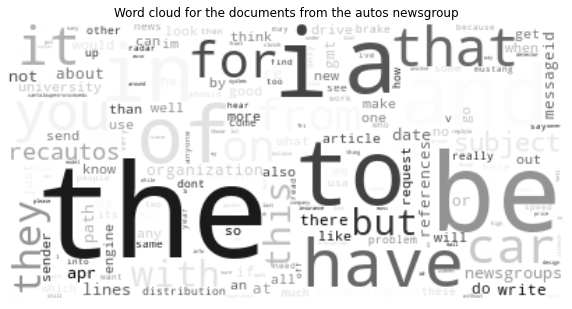

In [53]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 8))
wc = WordCloud(colormap='Greys', background_color='white')
im = wc.generate_from_frequencies(word_counts)
plt.imshow(im, interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud for the documents from the autos newsgroup')

plt.show()

Now we can visualize our text. However, they have such similar words. In the next chapter, we will learn how to address this issue.

## Exercises

We've visualized unigrams, but we have a problem with common words. Let's try visualizing N-grams. Try bigrams and trigrams.

## Resources

* Google Ngram Viewer: Google offers a way to look at the occurrence of N-grams in books through history.
* Hunspell: Hunspell is a very broadly used library for spell-checking and morphological analysis. 